In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0 : print('Available GPUs: {}'.format(gpus))
else             : print('!!! No GPUs found !!!')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


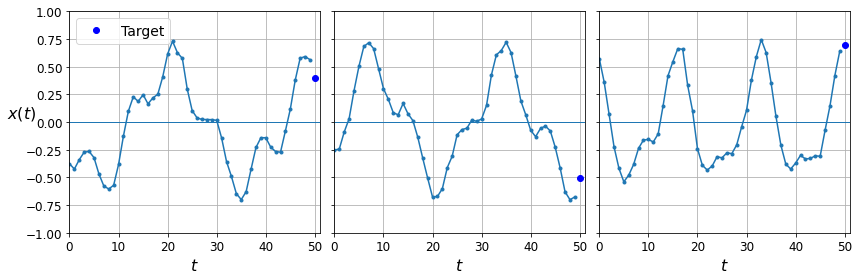

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087150901556

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,batch_size=256,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
28/28 [==============================] - 2s 52ms/step - loss: 0.2330 - val_loss: 0.1731
Epoch 2/20
28/28 [==============================] - 1s 48ms/step - loss: 0.1308 - val_loss: 0.1043
Epoch 3/20
28/28 [==============================] - 1s 48ms/step - loss: 0.0903 - val_loss: 0.0857
Epoch 4/20
28/28 [==============================] - 1s 49ms/step - loss: 0.0768 - val_loss: 0.0736
Epoch 5/20
28/28 [==============================] - 1s 48ms/step - loss: 0.0667 - val_loss: 0.0643
Epoch 6/20
28/28 [==============================] - 1s 48ms/step - loss: 0.0589 - val_loss: 0.0571
Epoch 7/20
28/28 [==============================] - 1s 53ms/step - loss: 0.0529 - val_loss: 0.0513
Epoch 8/20
28/28 [==============================] - 1s 48ms/step - loss: 0.0479 - val_loss: 0.0467
Epoch 9/20
28/28 [==============================] - 1s 48ms/step - loss: 0.0440 - val_loss: 0.0429
Epoch 10/20
28/28 [==============================] - 1s 53ms/step - loss: 0.0407 - val_loss: 0.0397
Epoch 11/

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10, batch_size=256,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
28/28 [==============================] - 4s 125ms/step - loss: 0.0867 - val_loss: 0.0365
Epoch 2/10
28/28 [==============================] - 3s 119ms/step - loss: 0.0253 - val_loss: 0.0161
Epoch 3/10
28/28 [==============================] - 3s 122ms/step - loss: 0.0126 - val_loss: 0.0091
Epoch 4/10
28/28 [==============================] - 3s 122ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 5/10
28/28 [==============================] - 3s 119ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 6/10
28/28 [==============================] - 3s 119ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 7/10
28/28 [==============================] - 3s 119ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/10
28/28 [==============================] - 3s 116ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/10
28/28 [==============================] - 3s 113ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/10
28/28 [==============================] - 3s 116ms/step - loss: 0.0039 - val_loss: 0.0037

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 22ms/step - loss: 0.0037


0.0036907594185322523

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10, batch_size=256,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
28/28 [==============================] - 4s 128ms/step - loss: 0.0897 - last_time_step_mse: 0.0838 - val_loss: 0.0510 - val_last_time_step_mse: 0.0420
Epoch 2/10
28/28 [==============================] - 3s 118ms/step - loss: 0.0473 - last_time_step_mse: 0.0359 - val_loss: 0.0447 - val_last_time_step_mse: 0.0326
Epoch 3/10
28/28 [==============================] - 3s 111ms/step - loss: 0.0440 - last_time_step_mse: 0.0318 - val_loss: 0.0428 - val_last_time_step_mse: 0.0297
Epoch 4/10
28/28 [==============================] - 3s 116ms/step - loss: 0.0434 - last_time_step_mse: 0.0314 - val_loss: 0.0420 - val_last_time_step_mse: 0.0296
Epoch 5/10
28/28 [==============================] - 3s 113ms/step - loss: 0.0422 - last_time_step_mse: 0.0299 - val_loss: 0.0438 - val_last_time_step_mse: 0.0320
Epoch 6/10
28/28 [==============================] - 3s 117ms/step - loss: 0.0421 - last_time_step_mse: 0.0297 - val_loss: 0.0418 - val_last_time_step_mse: 0.0305
Epoch 7/10
28/28 [==========

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# optimizer=keras.optimizers.Adam(learning_rate=0.01)
# optimizer="adam"
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 14ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0551 - val_last_time_step_mse: 0.0380
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0475 - last_time_step_mse: 0.0275 - val_loss: 0.0420 - val_last_time_step_mse: 0.0214
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0387 - last_time_step_mse: 0.0178 - val_loss: 0.0364 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0348 - last_time_step_mse: 0.0149 - val_loss: 0.0332 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0324 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0307 - last_time_step_mse: 0.0123 - val_loss: 0.0297 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [16]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023760905489325523, 0.008569398894906044]